<a href="https://colab.research.google.com/github/littlekii/DPBBP/blob/main/DP_SGD_vs_DP_SGLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opacus
!git clone https://github.com/JavierAntoran/Bayesian-Neural-Networks.git
!git clone https://github.com/knamdar/data.git

     |████████████████████████████████| 102kB 9.0MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


Cloning into 'Bayesian-Neural-Networks'...
remote: Enumerating objects: 369, done.
remote: Total 369 (delta 0), reused 0 (delta 0), pack-reused 369
Receiving objects: 100% (369/369), 15.98 MiB | 36.52 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Cloning into 'data'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [ ]:
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.utils.data as data
from torch.optim import Optimizer
from opacus import PrivacyEngine

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import collections
import h5py, sys
import gzip
import os
import math
import pickle

In [ ]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)


suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
  
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

In [ ]:
import torch.nn.functional as F
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

In [ ]:
from torch.optim.optimizer import Optimizer, required
class SGLD(Optimizer):
    """
    SGLD optimiser based on pytorch's SGD. 
    Note that the weight decay is specified in terms of the gaussian prior sigma
    """

    def __init__(self, params, lr=required, norm_sigma=0,laplace_b=0, addnoise=True):
        
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        
        defaults = dict(lr=lr, norm_sigma=norm_sigma, laplace_b=laplace_b,addnoise=addnoise)
        
        super(SGLD, self).__init__(params, defaults)

    def step(self,closure=0):
        """
        Performs a single optimization step.
        """
        loss = None
        
        for group in self.param_groups:

            norm_sigma = group['norm_sigma']
            laplace_b=group['laplace_b']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if norm_sigma != 0:
                    p.data.add_(-group['lr']/norm_sigma**2, p.data)
                if laplace_b != 0:
                    p.data.add_(-group['lr']/laplace_b,torch.sign(p.data))

                if group['addnoise']:  
                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1)/np.sqrt(group['lr'])
                    p.data.add_(-group['lr'], 0.5*d_p + langevin_noise)
                else:
                    p.data.add_(-group['lr'], 0.5*d_p)

        return loss

In [ ]:
class SampleConvNet_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        # x of shape [B, 1, 28, 28]
        x = F.relu(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = F.relu(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = F.relu(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

    def name(self):
        return "SampleConvNet"

In [ ]:
class Net_langevin(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, cuda=True, classes=10, N_train=60000, norm_sigma=0,laplace_b=0,DP_or_Not=True,which_net=None,SGD_or_Not=False):
        super(Net_langevin, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.norm_sigma = norm_sigma
        self.laplace_b=laplace_b
        self.classes = classes
        self.N_train = N_train

        self.which_net=which_net
        self.create_net()
        self.SGD_or_Not=SGD_or_Not
        self.create_opt()
        self.epoch = 0
        self.weight_set_samples = []

        self.test=False
        self.DP_or_Not=DP_or_Not

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = self.which_net
        if self.cuda:
            self.model.cuda()
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))
    
    def create_opt(self):
        if self.SGD_or_Not:
            self.optimizer = optim.SGD(params=self.model.parameters(), lr=self.lr)
            if DP_or_Not:
                privacy_engine = PrivacyEngine(
                        self.model,
                        sample_rate=batch_size/self.N_train,
                        alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                        noise_multiplier=noise_multiplier,
                        max_grad_norm=clipping_norm)
                privacy_engine.attach(self.optimizer)

        else:
            self.optimizer = SGLD(params=self.model.parameters(), lr=self.lr, norm_sigma=self.norm_sigma,laplace_b=self.laplace_b, addnoise=1-DP_or_Not)
            if DP_or_Not:
                privacy_engine = PrivacyEngine(
                        self.model,
                        sample_rate=batch_size/self.N_train,
                        alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                        noise_multiplier=batch_size/np.sqrt(self.lr)/self.N_train/clipping_norm,
                        max_grad_norm=clipping_norm*self.N_train)
                privacy_engine.attach(self.optimizer)

    def fit(self, x, y):
        x, y = x.to(device), y.long().to(device)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='mean') # We use mean because we treat as an estimation of whole dataset
        
        if not self.SGD_or_Not:
           loss = loss * self.N_train 
            
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data*x.shape[0]/self.N_train, err


    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def save_sampled_net(self, max_samples):
        
        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)
            
        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))
        
        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples) )
        
        return None
        
    def sample_eval(self, x, y, Nsamples=0, logits=True, train=False):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
            
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        
        out = x.data.new(Nsamples, x.shape[0], self.classes)
        
        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)
        
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def all_sample_eval(self, x, y, Nsamples):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
            
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        
        out = x.data.new(Nsamples, x.shape[0], self.classes)
        
        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    def get_weight_samples(self, Nsamples=0):
        weight_vec = []
        
        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)
            
        for idx, state_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
                
            for key in state_dict.keys():
                if 'weight' in key:
                    weight_mtx = state_dict[key].cpu().data
                    for weight in weight_mtx.view(-1):
                        weight_vec.append(weight)
            
        return np.array(weight_vec)

In [ ]:
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib

## DP-SGD with different noise multiplier and clipping norm

In [ ]:
models_dir = 'models_SGLD_MNIST_gaussian'
results_dir = 'result_SGD_MNIST'

mkdir(models_dir)
mkdir(results_dir)

save_dicts = []
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 256
nb_epochs = 15 # We can do less iterations as this method has faster convergence
log_interval = 1

lr = 0.25
norm_sigma =0.1 
laplace_b=0
#noise_multiplier = 1.3
#clipping_norm=1.5
DP_or_Not=True
# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

 

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='/content/data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='/content/data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


########################################################################################
#net = Net_langevin(lr=lr, cuda=use_cuda, classes=10,N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=SampleConvNet_MNIST(),SGD_or_Not=True, noise_multiplier = noise_multiplier)

## weight saving parameters #######
start_save = 1
save_every = 1 # We want less correlated samples -> despite having per minibatch noise we see correlations
N_saves = 15
###################################


## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
from tqdm import tqdm

err_SGD_list = []

for noise_multiplier in [0.5,0.9,1.3,2,3]:
    for clipping_norm in [0.5,1,1.5,2,5]:
        net = Net_langevin(lr=lr, cuda=use_cuda, classes=10,N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=SampleConvNet_MNIST(),SGD_or_Not=True)
        for i in range(nb_epochs):
            
        #     if i in [1]:
        #         print('updating lr')
        #         net.sched.step()
            
            net.set_mode_train(True)

            tic = time.time()
            nb_samples = 0

            for x, y in tqdm(trainloader):
                cost_pred, err = net.fit(x, y)
                err_train[i] += err
                pred_cost_train[i] += torch.mean(cost_pred)
                nb_samples += len(x)

            pred_cost_train[i] /= nb_samples
            err_train[i] /= nb_samples

            toc = time.time()
            net.epoch = i
            # ---- print
            print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
            cprint('r', '   time: %f seconds\n' % (toc - tic))
            
            # ---- save weights
            if i >= start_save and i % save_every == 0:
                net.save_sampled_net(max_samples=N_saves)
                save_dicts.append(copy.deepcopy(net.model.state_dict()))
            # ---- dev
            if i % nb_its_dev == 0:
                net.set_mode_train(False)
                nb_samples = 0
                for j, (x, y) in enumerate(valloader):

                    cost, err, probs = net.eval(x, y)

                    cost_dev[i] += cost
                    err_dev[i] += err
                    nb_samples += len(x)

                cost_dev[i] /= nb_samples
                err_dev[i] /= nb_samples

                cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))
                err_SGD_list.append(err_dev[i])
                if err_dev[i] < best_err:
                    best_err = err_dev[i]
                    cprint('b', 'best test error')
                    net.save(models_dir+'/theta_best.dat')
        
        print('current noise multiplier is ',noise_multiplier, 'current clipping norm is ',clipping_norm)
        print(err_SGD_list)

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
#np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)
np.save(results_dir + '/save_dicts.npy',save_dicts )
np.save(results_dir + '/err_list_SGD.npy',err_SGD_list )


Data:

Network:

Train:
  init cost variables:

Net:
 Creating Net!! 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engin

    Total params: 0.03M


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 1/1 [00:10<00:00, 10.19s/it]

it 0/15, Jtr_pred = 0.000039, err = 0.901400,    time: 10.192263 seconds



    Jdev = 2.307876, err = 0.904200

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 1/1 [00:09<00:00,  9.90s/it]

it 1/15, Jtr_pred = 0.000038, err = 0.901400,    time: 9.903114 seconds

 saving weight samples 1/15


    Jdev = 2.302990, err = 0.904200



100%|██████████| 1/1 [00:09<00:00,  9.78s/it]

it 2/15, Jtr_pred = 0.000038, err = 0.901400,    time: 9.781692 seconds

 saving weight samples 2/15


    Jdev = 2.298546, err = 0.904200



100%|██████████| 1/1 [00:09<00:00,  9.96s/it]

it 3/15, Jtr_pred = 0.000038, err = 0.901383,    time: 9.963508 seconds

 saving weight samples 3/15


    Jdev = 2.294589, err = 0.904100

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 1/1 [00:09<00:00,  9.85s/it]

it 4/15, Jtr_pred = 0.000038, err = 0.901133,    time: 9.854241 seconds

 saving weight samples 4/15


    Jdev = 2.290977, err = 0.902600

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



100%|██████████| 1/1 [00:09<00:00,  9.75s/it]

it 5/15, Jtr_pred = 0.000038, err = 0.900350,    time: 9.758374 seconds

 saving weight samples 5/15


    Jdev = 2.287720, err = 0.899600

best test error
Writting models_SGLD_MNIST_gaussian/theta_best.dat



  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print(err_SGD_list)
np.save('/content/noise_clip.npy', err_SGD_list)

## DP-SGLD with different noise multiplier and clipping norm

In [ ]:
models_dir = 'models_SGLD_MNIST_gaussian'
results_dir = 'result_SGLD_MNIST'

mkdir(models_dir)
mkdir(results_dir)

save_dicts = []
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 256
nb_epochs = 15 # We can do less iterations as this method has faster convergence
log_interval = 1

lr = 1e-5
norm_sigma =0.1 
laplace_b=0
#noise_multiplier = 1.3
#clipping_norm=1.5
DP_or_Not=True
# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')

 

# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='/content/data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='/content/data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')


########################################################################################
#net = Net_langevin(lr=lr, cuda=use_cuda, classes=10,N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=SampleConvNet_MNIST(),SGD_or_Not=False)

## weight saving parameters #######
start_save = 1
save_every = 1 # We want less correlated samples -> despite having per minibatch noise we see correlations
N_saves = 15
###################################


## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
from tqdm import tqdm

err_SGLD_list = []

for clipping_norm in [0.5,1,1.5,2,5]:
    net = Net_langevin(lr=lr, cuda=use_cuda, classes=10,N_train=NTrainPointsMNIST, norm_sigma=norm_sigma,laplace_b=laplace_b,which_net=SampleConvNet_MNIST(),SGD_or_Not=False)
    for i in range(nb_epochs):
        
    #     if i in [1]:
    #         print('updating lr')
    #         net.sched.step()
        
        net.set_mode_train(True)

        tic = time.time()
        nb_samples = 0

        for x, y in tqdm(trainloader):
            cost_pred, err = net.fit(x, y)
            err_train[i] += err
            pred_cost_train[i] += torch.mean(cost_pred)
            nb_samples += len(x)

        pred_cost_train[i] /= nb_samples
        err_train[i] /= nb_samples

        toc = time.time()
        net.epoch = i
        # ---- print
        print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
        cprint('r', '   time: %f seconds\n' % (toc - tic))
        
        # ---- save weights
        if i >= start_save and i % save_every == 0:
            net.save_sampled_net(max_samples=N_saves)
            save_dicts.append(copy.deepcopy(net.model.state_dict()))
        # ---- dev
        if i % nb_its_dev == 0:
            net.set_mode_train(False)
            nb_samples = 0
            for j, (x, y) in enumerate(valloader):

                cost, err, probs = net.eval(x, y)

                cost_dev[i] += cost
                err_dev[i] += err
                nb_samples += len(x)

            cost_dev[i] /= nb_samples
            err_dev[i] /= nb_samples

            cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))
            err_SGLD_list.append(err_dev[i])
            if err_dev[i] < best_err:
                best_err = err_dev[i]
                cprint('b', 'best test error')
                net.save(models_dir+'/theta_best.dat')
    
    print('current clipping norm is ',clipping_norm)
    print(err_SGLD_list)

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir+'/theta_last.dat')

## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
#np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)
np.save(results_dir + '/save_dicts.npy',save_dicts )
np.save(results_dir + '/err_SGLD_list.npy',err_SGLD_list )

In [ ]:
print(err_SGLD_list)

np.save('/content/sgld_noise_clip.npy', err_SGD_list)

## Compute epsilon

In [ ]:
from numpy import array
err_SGD_list = [0.2322, 0.1485, 0.1161, 0.1003, 0.092, 0.0857, 0.0832, 0.076, 0.0731, 0.0691, 0.0677, 0.0641, 0.0631, 0.0611, 0.0606, 0.2473232177734375, 0.14261484375, 0.13071160888671876, 0.09811002807617188, 0.08230919799804688, 0.0737085693359375, 0.07210831909179688, 0.059107598876953125, 0.05160731201171875, 0.0493069091796875, 0.04930676879882812, 0.04620640869140625, 0.04180631103515625, 0.04200610961914063, 0.040506060791015625, 0.2214247314453125, 0.1012142578125, 0.08401307373046875, 0.064809814453125, 0.0552082275390625, 0.053007373046875, 0.05170721435546875, 0.043205911254882816, 0.04110516052246094, 0.039604931640625, 0.046104931640625, 0.03990462036132812, 0.034204180908203125, 0.03430419921875, 0.03160404968261719, 0.1661221435546875, 0.07831011962890624, 0.0581083984375, 0.05060648193359375, 0.04720552062988281, 0.03970530090332031, 0.039705169677734374, 0.0361043212890625, 0.03340411071777344, 0.03220396118164062, 0.03540461120605469, 0.03320399169921875, 0.03170342102050781, 0.03210343017578125, 0.03340316162109375, 0.06201661376953125, 0.045107830810546874, 0.038605810546875, 0.04030505981445313, 0.03680472106933594, 0.039003970336914065, 0.03960397033691406, 0.03440361022949219, 0.04070333862304688, 0.03680321960449219, 0.0386035400390625, 0.0411033203125, 0.03730317077636719, 0.04120321044921875, 0.042103338623046875, 0.318806201171875, 0.2034045166015625, 0.189103857421875, 0.1469040283203125, 0.1335036865234375, 0.12200390625, 0.115903955078125, 0.0982034423828125, 0.09400407104492188, 0.08470368041992188, 0.079603857421875, 0.07160411376953126, 0.06760372924804688, 0.06350411987304687, 0.06220421142578125, 0.268631884765625, 0.1438203369140625, 0.11771890869140625, 0.09081469116210937, 0.08141334838867187, 0.07531220092773437, 0.07081159057617188, 0.06370982055664062, 0.0538093994140625, 0.0537084716796875, 0.053207958984375, 0.049407159423828124, 0.04990675964355469, 0.047006350708007814, 0.04470621948242187, 0.22012685546875, 0.1044143798828125, 0.07511177368164063, 0.06490908203125, 0.05970814208984375, 0.05510753173828125, 0.053607080078125, 0.0501063720703125, 0.04750538024902344, 0.04260537109375, 0.040805322265625, 0.04230494079589844, 0.03990499267578125, 0.04000469970703125, 0.04180447082519531, 0.16722200927734376, 0.08551044311523437, 0.06060750732421875, 0.062206494140625, 0.06020596923828125, 0.04890551147460938, 0.05180535888671875, 0.049005010986328125, 0.04580474853515625, 0.04380426025390625, 0.04270408020019531, 0.04660422973632813, 0.04490399169921875, 0.03830400085449219, 0.04010418090820313, 0.0799167236328125, 0.07560855102539063, 0.06500606079101562, 0.059406219482421876, 0.07140601806640624, 0.07300488891601563, 0.08630518188476563, 0.06550490112304687, 0.07960457763671876, 0.08440438232421875, 0.0755042724609375, 0.0768046630859375, 0.0777044921875, 0.0804038330078125, 0.07920401000976562, 0.3316080078125, 0.207107568359375, 0.193606494140625, 0.1498059326171875, 0.13540714111328125, 0.1171072998046875, 0.10630863037109375, 0.09710654907226562, 0.091407958984375, 0.08380844116210938, 0.08290755004882812, 0.07660767822265625, 0.07160776977539063, 0.06800804443359375, 0.06500792236328125, 0.247733154296875, 0.143520703125, 0.1516193603515625, 0.10061497802734375, 0.08071353759765625, 0.07361171264648438, 0.06731063232421874, 0.06820971069335938, 0.05770914306640625, 0.055808380126953126, 0.06520828857421875, 0.055707659912109374, 0.05760715942382812, 0.05470679931640625, 0.05170650024414063, 0.2147247802734375, 0.11991435546875, 0.1060151611328125, 0.07211005859375, 0.06240806884765625, 0.06340736083984375, 0.06250673217773438, 0.05480682373046875, 0.05410577392578125, 0.05570557861328125, 0.0533065185546875, 0.05190557250976562, 0.05410576171875, 0.05250546875, 0.055705169677734374, 0.16842147216796874, 0.08521199340820312, 0.060010601806640626, 0.06880721435546874, 0.06240623779296875, 0.059706341552734375, 0.06670625, 0.06030548095703125, 0.06130540771484375, 0.07100557250976562, 0.06410533447265625, 0.07740518798828125, 0.08170540771484375, 0.0671052490234375, 0.06410557250976562, 0.118316845703125, 0.0852085205078125, 0.09860599975585937, 0.106906884765625, 0.13390623779296876, 0.12500596923828125, 0.1243066650390625, 0.1100060302734375, 0.1235061279296875, 0.1192071044921875, 0.12300640869140625, 0.1312077392578125, 0.11660816650390625, 0.1446067138671875, 0.12000640869140625, 0.33771181640625, 0.2109085205078125, 0.19760986328125, 0.156710693359375, 0.13741339111328124, 0.1203125, 0.1094124267578125, 0.09821099853515625, 0.095712353515625, 0.08861192016601563, 0.0877123046875, 0.08181312255859376, 0.07401165771484375, 0.07041445922851562, 0.06761199951171876, 0.2391337646484375, 0.15082109375, 0.15221976318359376, 0.110115673828125, 0.0906137451171875, 0.08061203002929687, 0.0798109375, 0.07510982055664063, 0.0723095703125, 0.0723088623046875, 0.07530877075195312, 0.0778081787109375, 0.0736073974609375, 0.06780704345703124, 0.0732067626953125, 0.20992392578125, 0.118915087890625, 0.15011522216796874, 0.0931110107421875, 0.0996090576171875, 0.111908056640625, 0.1047079833984375, 0.08770750732421875, 0.1100072265625, 0.1032072265625, 0.10240753173828125, 0.09070778198242188, 0.09780736083984375, 0.09090678100585937, 0.10930732421875, 0.16272099609375, 0.0942118896484375, 0.1015150146484375, 0.12200931396484375, 0.1038099609375, 0.13691119384765624, 0.1240104736328125, 0.1134087646484375, 0.11231099853515625, 0.1202103271484375, 0.15001024169921875, 0.16400906982421876, 0.12190977783203125, 0.12250909423828125, 0.1340109375, 0.17991627197265625, 0.251109423828125, 0.20571015625, 0.26041220703125, 0.2631103759765625, 0.2005136962890625, 0.21061240234375, 0.229611328125, 0.34031123046875, 0.29971201171875, 0.318014990234375, 0.34081640625, 0.22751220703125, 0.230112255859375, 0.2470134033203125, 0.3121179931640625, 0.18662510986328126, 0.16012056884765624, 0.14852603759765626, 0.133626318359375, 0.1245200439453125, 0.1115210693359375, 0.10852296142578124, 0.100634033203125, 0.09672996826171874, 0.09503179931640625, 0.09413408203125, 0.09052275390625, 0.09112301025390625, 0.08852470092773437, 0.266931201171875, 0.17081866455078126, 0.142416015625, 0.13381485595703124, 0.1171133544921875, 0.132112451171875, 0.1313111572265625, 0.15141085205078125, 0.11121005859375, 0.12270966796875, 0.1410094970703125, 0.15120941162109375, 0.1252090576171875, 0.1353091064453125, 0.13460885009765625, 0.238726708984375, 0.15871708984375, 0.2248142578125, 0.15391337890625, 0.20981171875, 0.1799132080078125, 0.167013134765625, 0.14891513671875, 0.15471112060546874, 0.17961226806640626, 0.16481409912109374, 0.15871512451171876, 0.1869125244140625, 0.152413525390625, 0.15681346435546875, 0.262723876953125, 0.196815869140625, 0.1628224853515625, 0.17771539306640624, 0.23612099609375, 0.2068179931640625, 0.17161669921875, 0.168614892578125, 0.167415478515625, 0.16251796875, 0.2039164794921875, 0.162415869140625, 0.20361868896484375, 0.175515234375, 0.176715673828125, 0.31172626953125, 0.344719677734375, 0.47671630859375, 0.5089177734375, 0.5142236328125, 0.521020703125, 0.7755171875, 0.704316845703125, 0.731416748046875, 0.817616259765625, 0.83372041015625, 0.8301162109375, 0.8814203125, 0.887017578125, 0.88611767578125]
err_SGLD_list = [0.3423, 0.2554, 0.266, 0.1889, 0.1636, 0.1369, 0.1367, 0.1116, 0.1059, 0.1107, 0.1038, 0.0939, 0.093, 0.0942, 0.0929, 0.257934228515625, 0.132525537109375, 0.10762659912109375, 0.08281889038085938, 0.100216357421875, 0.06801369018554687, 0.070713671875, 0.0634111572265625, 0.06121058959960937, 0.05521107177734375, 0.0665103759765625, 0.05850938720703125, 0.0608093017578125, 0.056709423828125, 0.05650928955078125, 0.22042578125, 0.1031132568359375, 0.0860107666015625, 0.06880828247070313, 0.06651002197265625, 0.05150679931640625, 0.05890706787109375, 0.04920634155273437, 0.05590612182617188, 0.04710552062988281, 0.07930665283203125, 0.04780585021972656, 0.0502060791015625, 0.05050567016601563, 0.04440565185546875, 0.1575220458984375, 0.06951031494140625, 0.06480859985351563, 0.058306884765625, 0.05510665283203125, 0.0465051513671875, 0.056005889892578126, 0.04910491943359375, 0.0441055908203125, 0.0468047119140625, 0.0636079345703125, 0.04560477905273438, 0.043105020141601565, 0.0512050537109375, 0.04280444030761719, 0.06181575317382813, 0.03970695190429688, 0.04640648193359375, 0.03370582885742188, 0.03820551147460938, 0.02890465087890625, 0.06760560302734375, 0.030904910278320312, 0.030204409790039063, 0.027104681396484375, 0.03770635986328125, 0.040004559326171876, 0.02590430908203125, 0.03240512084960938, 0.030804278564453124]

In [ ]:
!pip install tensorflow_privacy

In [ ]:
r"""This code applies the moments accountant (MA), Dual and Central Limit 
Theorem (CLT) to estimate privacy budget of an iterated subsampled 
Gaussian Mechanism (either uniformly or by Poisson subsampling). 
The mechanism's parameters are controlled by flags.
Example:
  compute_muP
    --N=60000 \
    --batch_size=256 \
    --noise_multiplier=1.3 \
    --epochs=15
The output states that DP-optimizer satisfies 0.227-GDP.
"""

import numpy as np
from scipy.stats import norm
from scipy import optimize

# Total number of examples:N
# batch size:batch_size
# Noise multiplier for DP-SGD/DP-Adam:noise_multiplier
# current epoch:epoch
# Target delta:delta

# Compute mu from uniform subsampling
def compute_muU(epoch,noise_multi,N,batch_size):
    T=epoch*N/batch_size
    c=batch_size*np.sqrt(T)/N
    return(np.sqrt(2)*c*np.sqrt(np.exp(noise_multi**(-2))*norm.cdf(1.5/noise_multi)+3*norm.cdf(-0.5/noise_multi)-2))

# Compute mu from Poisson subsampling
def compute_muP(epoch,noise_multi,N,batch_size):
    T=epoch*N/batch_size
    return(np.sqrt(np.exp(noise_multi**(-2))-1)*np.sqrt(T)*batch_size/N)
    
# Dual between mu-GDP and (epsilon,delta)-DP
def delta_eps_mu(eps,mu):
    return norm.cdf(-eps/mu+mu/2)-np.exp(eps)*norm.cdf(-eps/mu-mu/2)

# inverse Dual
def eps_from_mu(mu,delta):
    def f(x):
        return delta_eps_mu(x,mu)-delta    
    return optimize.root_scalar(f, bracket=[0, 500], method='brentq').root

# inverse Dual of uniform subsampling
def compute_epsU(epoch,noise_multi,N,batch_size,delta):
    return(eps_from_mu(compute_muU(epoch,noise_multi,N,batch_size),delta))

# inverse Dual of Poisson subsampling
def compute_epsP(epoch,noise_multi,N,batch_size,delta):
    return(eps_from_mu(compute_muP(epoch,noise_multi,N,batch_size),delta))

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent

# Compute epsilon by MA
def compute_epsilon(epoch,noise_multi,N,batch_size,delta):
  """Computes epsilon value for given hyperparameters."""
  orders = [1 + x / 10. for x in range(1, 100)] + list(np.arange(12, 60,0.2))+list(np.arange(60,100,1))
  sampling_probability = batch_size / N
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=noise_multi,
                    steps=epoch*N/batch_size,
                    orders=orders)
  return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [ ]:
def mu_SGD(epoch, noise_multi, batch_size, N):
    return np.sqrt(epoch * (np.exp(1/(noise_multi**2) - 1 )) ) * batch_size/N

def mu_SGLD(epoch, batch_size, N, clipping_norm, lr):
    noise_multi = batch_size/N/clipping_norm/np.sqrt(lr)
    return np.sqrt(epoch * (np.exp(1/(noise_multi**2) - 1 )) ) * batch_size/N

In [ ]:
from numpy import array


epsilon_SGD_list = np.zeros(375)
epsilon_SGLD_list = np.zeros(75)

k = 0
for noise_multiplier in [0.5,0.9,1.3,2,3]:
    for clipping_norm in [0.5,1,1.5,2,5]:
        for epoch in [1*14,2*14,3*14,4*14,5*14,6*14,7*14,8*14,9*14,10*14,11*14,12*14,13*14,14*14,15*14]:
            epsilon_SGD_list[k] = eps_from_mu(mu_SGD(epoch, noise_multiplier, 256, 60000),1/100000)
            k += 1


k = 0
for clipping_norm in [0.5,1,1.5,2,5]:
    for epoch in [1*7,2*7,3*7,4*7,5*7,6*7,7*7,8*7,9*7,10*7,11*7,12*7,13*7,14*7,15*7]:
        epsilon_SGLD_list[k] = eps_from_mu(mu_SGLD(epoch, 256, 60000, clipping_norm, 1e-5),1/100000)
        k += 1

  



In [ ]:
print(epsilon_SGD_list)

[0.13490288 0.19692489 0.24562017 0.28728771 0.3244101  0.35827516
 0.38965448 0.41905427 0.44682817 0.47323495 0.49847081 0.52268876
 0.54601091 0.56853658 0.59034785 0.13490288 0.19692489 0.24562017
 0.28728771 0.3244101  0.35827516 0.38965448 0.41905427 0.44682817
 0.47323495 0.49847081 0.52268876 0.54601091 0.56853658 0.59034785
 0.13490288 0.19692489 0.24562017 0.28728771 0.3244101  0.35827516
 0.38965448 0.41905427 0.44682817 0.47323495 0.49847081 0.52268876
 0.54601091 0.56853658 0.59034785 0.13490288 0.19692489 0.24562017
 0.28728771 0.3244101  0.35827516 0.38965448 0.41905427 0.44682817
 0.47323495 0.49847081 0.52268876 0.54601091 0.56853658 0.59034785
 0.13490288 0.19692489 0.24562017 0.28728771 0.3244101  0.35827516
 0.38965448 0.41905427 0.44682817 0.47323495 0.49847081 0.52268876
 0.54601091 0.56853658 0.59034785 0.02943242 0.04322255 0.05406531
 0.06334678 0.07161564 0.07915731 0.08614315 0.09268575 0.0988639
 0.1047353  0.11034374 0.11572342 0.12090163 0.1259006  0.13073

In [ ]:
print(epsilon_SGLD_list)

[1.59401250e-02 2.35003162e-02 2.94549054e-02 3.45569388e-02
 3.91052115e-02 4.32553794e-02 4.71009983e-02 5.07035991e-02
 5.41062570e-02 5.73405456e-02 6.04304406e-02 6.33946660e-02
 6.62481819e-02 6.90031695e-02 7.16697069e-02 2.00833905e-02
 2.95619064e-02 3.70221095e-02 4.34116259e-02 4.91061065e-02
 5.43011304e-02 5.91141978e-02 6.36225618e-02 6.78802884e-02
 7.19269983e-02 7.57927714e-02 7.95010946e-02 8.30707305e-02
 8.65169540e-02 8.98524014e-02 2.94552415e-02 4.32558702e-02
 5.41068691e-02 6.33953819e-02 7.16705151e-02 7.92179003e-02
 8.62090272e-02 9.27565866e-02 9.89394124e-02 1.04815254e-01
 1.10427942e-01 1.15811689e-01 1.20993821e-01 1.25996577e-01
 1.30838353e-01 5.01608811e-02 7.34649476e-02 9.17692887e-02
 1.07429849e-01 1.21377629e-01 1.34096384e-01 1.45876317e-01
 1.56908009e-01 1.67324710e-01 1.77223989e-01 1.86679870e-01
 1.95750113e-01 2.04480837e-01 2.12909566e-01 2.21067332e-01
 3.83563687e+01 6.35232091e+01 8.64358376e+01 1.08177536e+02
 1.29169586e+02 1.496285

## Plot

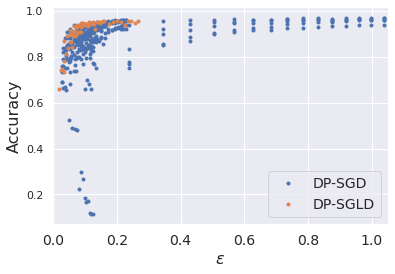

In [ ]:
import matplotlib.pyplot as plt;
import numpy as np;
import scipy.optimize as opt;



# Generate some data, you don't have to do this, as you already have your data

xdata1 = epsilon_SGD_list
ydata1 = np.ones(375) - err_SGD_list

xdata2 = epsilon_SGLD_list
ydata2 = np.ones(75) -  err_SGLD_list

# Plot the actual data
plt.plot(xdata1, ydata1, ".", label="DP-SGD")
plt.plot(xdata2, ydata2, ".", label="DP-SGLD")

plt.xlim([0, 1.05])

plt.xlabel(r'$\epsilon$',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)

plt.legend(loc=4, prop={'size': 14})
plt.xticks(fontsize= 14 )

# Use the optimized parameters to plot the best fit
# Show the graph

plt.savefig('DP_SGD_vs_DP_SGLD.pdf',bbox_inches = 'tight')
plt.show()

